In [338]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.interpolate import interp2d

from hw2 import lRGB2XYZ
from cv2 import GaussianBlur
from scipy.signal import correlate2d
import skimage

### 1. Lightfield rendering, depth from focus, and confocal stereo (100 points)

In [196]:
'''Initials (5 points). Block of 16 ×16 pixels --> 400x700'''

plenoptic_image = Image.open('data/chessboard_lightfield.png')
plenoptic_image = np.array(plenoptic_image) #(6400, 11200, 3)

s_range = np.arange(0, 6400, 16)
t_range = np.arange(0, 11200, 16)
lf_image = np.zeros((16, 16, 400, 700, 3))

for s in s_range:
    for t in t_range:
        
        circle = plenoptic_image[s:s+16, t:t+16, :]
        
        lf_image[:, :, int(s/16), int(t/16), :] = circle

##### Sub-aperture views (20 points)

In [ ]:
# mosaic = np.zeros_like(plenoptic_image)

# for i in range(16):
#     for j in range(16):
#         im = lf_image[i, j, :, :, :]
#         mosaic[i*400:i*400+400, j*700:j*700+700, :] = im
        
# fig = plt.figure(figsize=(20., 20.))
# grid = ImageGrid(fig,111,
#                 nrows_ncols=(16, 16),  # creates 2x2 grid of axes
#                 axes_pad=0,  # pad between axes in inch.
#                 )

# for ax, im in zip(grid, lf_image.reshape(16*16, 400, 700, 3)):
#     # Iterating over the grid returns the Axes.
#     ax.imshow(im.astype(np.uint8))
#     ax.axis('off')
# plt.axis('off')
# plt.show()

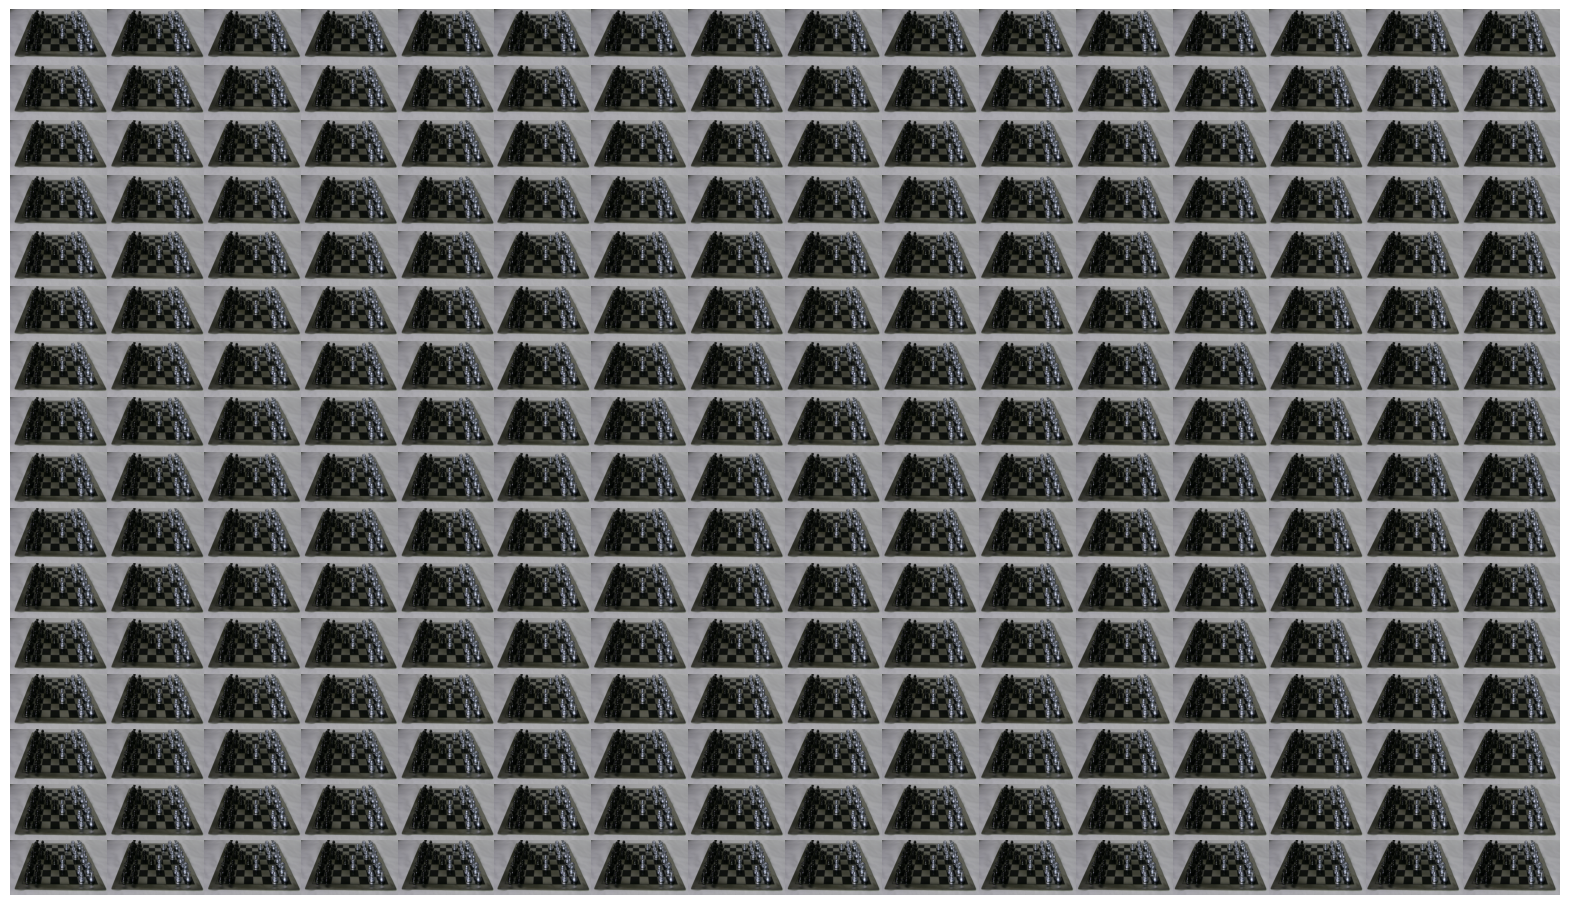

##### Refocusing and focal-stack simulation (25 points).

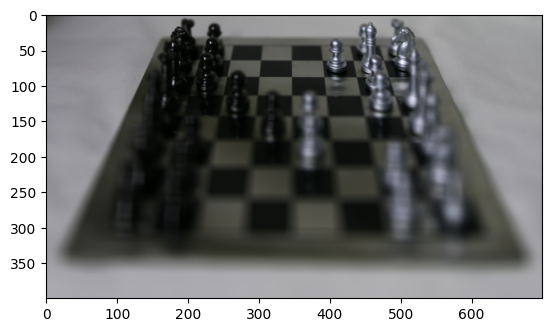

In [247]:
lensletSize = 16
maxUV = (lensletSize - 1) // 2
u = np.arange(lensletSize) - maxUV
v = np.arange(lensletSize) - maxUV

'''(array([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8]),
 array([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8]))'''
 
 
focus = np.zeros((400, 700, 3))

for i in (u):
    for j in (v):
        focus += lf_image[i, j, :, :, :]
        
focus /= 256

plt.imshow(focus.astype(np.uint8))

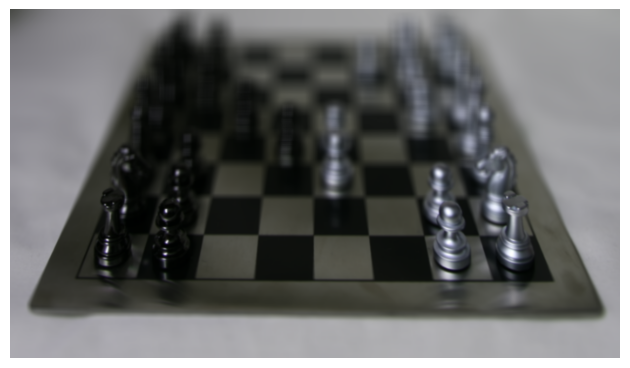

In [51]:
def refocus(lf, d=0, lightfieldSize=16):
    
    #lf :16, 16, 400, 700, 3
    
    maxUV = (lensletSize - 1) // 2
    u = np.arange(lensletSize) - maxUV
    v = np.arange(lensletSize) - maxUV
    
    _,_, h, w, c = lf.shape
    
    focus = np.zeros((h, w, c))

    for i in (u): #400
        for j in (v): #700
            
            # Fit a function to an image
            
            x = np.arange(h) #400
            y = np.arange(w) #700
            
            s = x+d*i #400
            t = y-d*j #700
            
            zr = lf_image[i+7, j+7, :, :, 0].T
            zg = lf_image[i+7, j+7, :, :, 1].T
            zb = lf_image[i+7, j+7, :, :, 2].T
            
            inter_funr = interp2d(x, y, zr, kind='linear')
            inter_fung = interp2d(x, y, zg, kind='linear')
            inter_funb = interp2d(x, y, zb, kind='linear')
            
            inter_r = inter_funr(s, t).T
            inter_g = inter_fung(s, t).T
            inter_b = inter_funb(s, t).T
            
            focus[:,:,0] += inter_r
            focus[:,:,1] += inter_g
            focus[:,:,2] += inter_b
            
    return focus/256
        
focus2 = refocus(lf_image, d=1.3)
plt.axis('off')
plt.tight_layout()
plt.imshow(focus2.astype(np.uint8))

##### All-in-focus image and depth from focus (25 points).

In [55]:
'''For every image in the focal stack, first convert it to the XYZ colorspace (making sure to account for
gamma encoding), and extract the luminance channel'''


def gamma_encoding(clr):

    gamma_encoding = lambda x: np.where(x <= 0.0031308, 12.92*x, 1.055*x**(1/2.4)-0.055)
    img_tone = gamma_encoding(np.clip(clr*3.45,0,1))

    return img_tone

I_stcd = lRGB2XYZ(refocus(lf_image, d=1.3))
I_std = I_stcd[:,:,1]

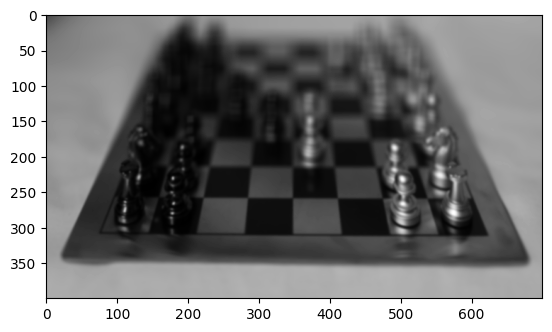

In [67]:
I_low_freq = GaussianBlur(I_std, (5,5), 1)
plt.imshow(I_low_freq, cmap='gray')

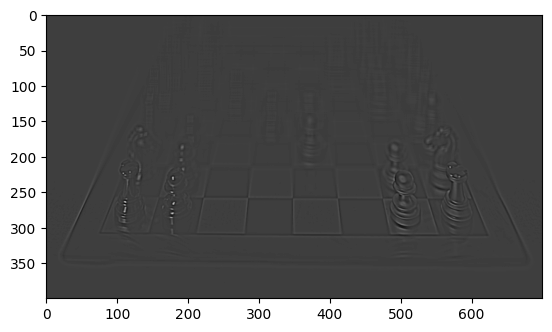

In [68]:
I_high_freq = I_std - I_low_freq
plt.imshow(I_high_freq, cmap='gray')

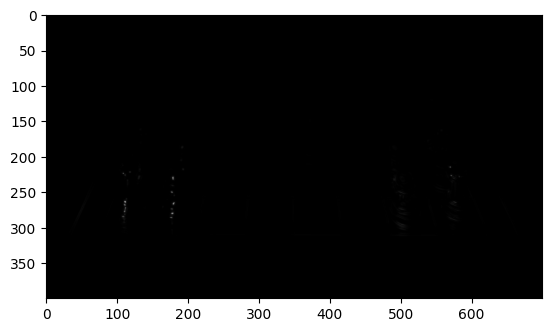

In [81]:
w_sharpness = GaussianBlur(I_high_freq**2, (5,5), 0.5)
plt.imshow(w_sharpness, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 699.5, 399.5, -0.5)

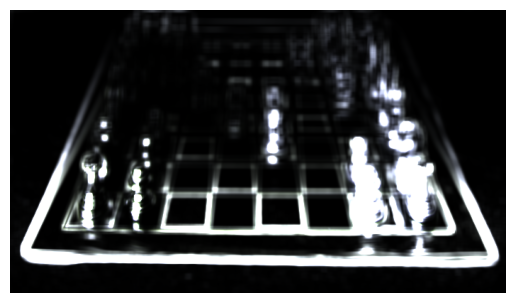

In [152]:
a = I_stcd*w_sharpness[...,None]
plt.imshow((a-np.min(a))/(np.max(a)-np.min(a))*255)
plt.axis('off')

In [146]:
d_range = np.linspace(0, 1.5, 5, dtype=np.float32)

image_stack = []
weight_stack = []

for d in d_range:
    
    I_stcd = lRGB2XYZ(refocus(lf_image, d=d))
    I_std = I_stcd[:,:,1]
    
    I_low_freq = GaussianBlur(I_std, (9,9), 9)
    I_high_freq = I_std - I_low_freq
    
    w_sharpness = GaussianBlur(I_high_freq**2, (9,9), 9)
    
    a = I_stcd*w_sharpness[...,None]
    
    image_stack.append(a)
    weight_stack.append(w_sharpness)
    
image_stack = np.array(image_stack)
weight_stack = np.array(weight_stack)

print(image_stack.shape, weight_stack.shape)    

(5, 400, 700, 3) (5, 400, 700)


(-0.5, 699.5, 399.5, -0.5)

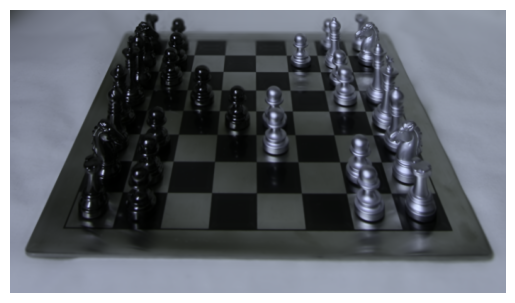

In [127]:
I_infocus = np.sum(image_stack, axis=0)/np.sum(weight_stack, axis=0)[...,None]
plt.imshow((I_infocus-np.min(I_infocus))/(np.max(I_infocus)-np.min(I_infocus)))
plt.axis('off')

(5, 400, 700) (400, 700)


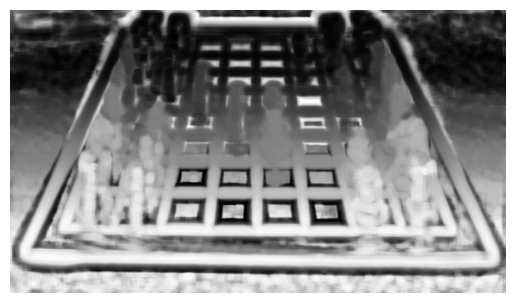

In [148]:
num = weight_stack*d_range[...,None, None]
denom = np.sum(weight_stack, axis=0)

print(num.shape, denom.shape)

d_map = np.sum(num, axis=0)/denom

d_map = (d_map-np.min(d_map))/(np.max(d_map)-np.min(d_map))
plt.axis('off')
plt.imshow(d_map, cmap='gray')


In [169]:
def depth_from_defocus(lf_image, sigma1, sigma2):
    
    image_stack = []
    weight_stack = []
    
    d_range = np.linspace(0., 1.8, 10, dtype=np.float32)

    for d in d_range:

        I_stcd = lRGB2XYZ(refocus(lf_image, d=d))
        I_std = I_stcd[:,:,1]

        I_low_freq = GaussianBlur(I_std, (4*sigma1+1,4*sigma1+1), sigma1)
        I_high_freq = I_std - I_low_freq

        w_sharpness = GaussianBlur(I_high_freq**2, (4*sigma2+1,4*sigma2+1), sigma2)

        a = I_stcd*w_sharpness[...,None]

        image_stack.append(a)
        weight_stack.append(w_sharpness)

    image_stack = np.array(image_stack)
    weight_stack = np.array(weight_stack)

    I_infocus = np.sum(image_stack, axis=0)/np.sum(weight_stack, axis=0)[...,None]
    
    num = weight_stack*d_range[...,None, None]
    denom = np.sum(weight_stack, axis=0)

    d_map = np.sum(num, axis=0)/denom
    
    return I_infocus, d_map

(-0.5, 699.5, 399.5, -0.5)

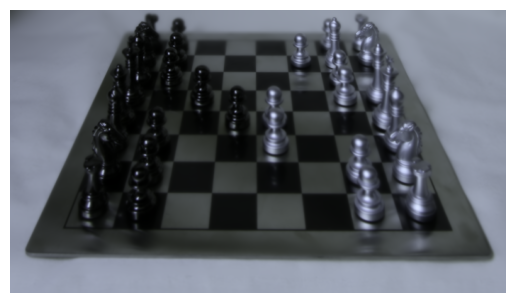

In [170]:
i, d = depth_from_defocus(lf_image, 5, 5)
plt.imshow((i-np.min(i))/(np.max(i)-np.min(i)))
plt.axis('off')

(-0.5, 699.5, 399.5, -0.5)

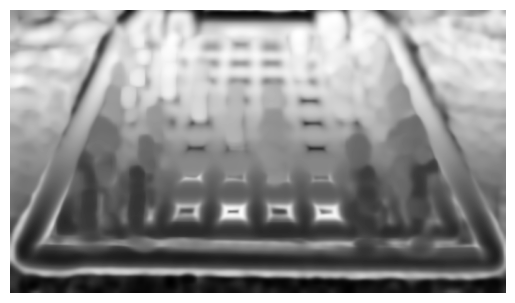

In [172]:
plt.imshow(1-d, cmap='gray')
plt.axis('off')

##### Focal-aperture stack and confocal stereo (25 points).

In [197]:
def confocal(lf, u, v, d=0):
    
    #lf :16, 16, 400, 700, 3
    
    _,_, h, w, c = lf.shape
    
    focus = np.zeros((h, w, c))

    for i in (u): #400
        for j in (v): #700
            
            # Fit a function to an image
            
            x = np.arange(h) #400
            y = np.arange(w) #700
            
            s = x+d*i #400
            t = y-d*j #700
            
            zr = lf_image[i+7, j+7, :, :, 0].T
            zg = lf_image[i+7, j+7, :, :, 1].T
            zb = lf_image[i+7, j+7, :, :, 2].T
            
            inter_funr = interp2d(x, y, zr, kind='linear')
            inter_fung = interp2d(x, y, zg, kind='linear')
            inter_funb = interp2d(x, y, zb, kind='linear')
            
            inter_r = inter_funr(s, t).T
            inter_g = inter_fung(s, t).T
            inter_b = inter_funb(s, t).T
            
            focus[:,:,0] += inter_r
            focus[:,:,1] += inter_g
            focus[:,:,2] += inter_b
            
    return focus/(len(u)*len(v))

In [198]:
def get_af_range(aperture_stack=16):
    
    maxUV = (lensletSize - 1) // 2
    u = np.arange(lensletSize) - maxUV
    v = np.arange(lensletSize) - maxUV
    
    '''(array([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8]),
        array([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8]))'''
    mid = aperture_stack//2 #4
    u = u[maxUV-mid+1:maxUV+mid+1] #[-3, -2, -1,  0,  1,  2,  3,  4]
    v = v[maxUV-mid+1:maxUV+mid+1]
    
    return u, v

def confocal_stack(lf_image):
    
    '''
    aperture_stack: 16,14,12,10,8
    '''
    
    aperture_stack = np.array([16,14,12,10,8])
    depth_stack = np.linspace(0, 1.5, 10, dtype=np.float32)
    
    af_stack = []
    
    for aperture in aperture_stack:
        u, v = get_af_range(aperture)
        focal_stack = []
        
        for focus in depth_stack:
    
            image_refocus = confocal(lf_image, u, v, focus)
            focal_stack.append(image_refocus)
        
        af_stack.append(focal_stack)
        
        
    return np.array(af_stack)

In [199]:
af = confocal_stack(lf_image)

In [200]:
af.shape

(5, 10, 400, 700, 3)

(-0.5, 9.5, 4.5, -0.5)

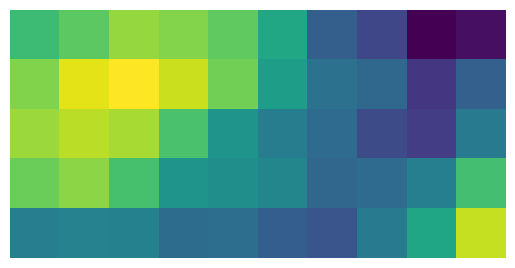

In [347]:
plt.imshow(skimage.color.rgb2xyz(af)[:,:,:,:,1][:,:,380,600])
plt.axis('off')

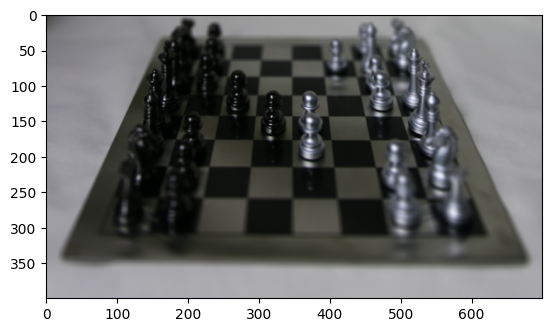

In [180]:
plt.imshow(af[3][3].astype(np.uint8))

(-0.5, 699.5, 399.5, -0.5)

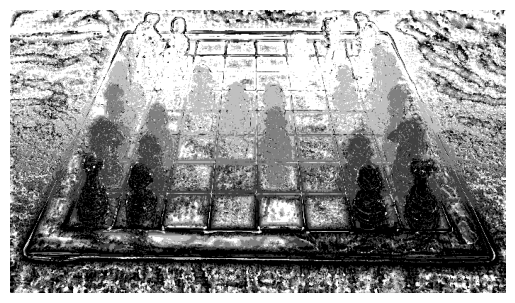

In [227]:
af_r = af[:,:,:,:,0]
af_g = af[:,:,:,:,1]
af_b = af[:,:,:,:,2]

var_r = np.var(af_r, axis=(0))
var_g = np.var(af_g, axis=(0))
var_b = np.var(af_b, axis=(0))

print(var_r.shape, var_g.shape, var_b.shape)

a_r = np.argmin(var_r, 0)
a_g = np.argmin(var_g, 0)
a_b = np.argmin(var_b, 0)
a.max(), a.min()

depth_stack = np.linspace(0, 1.5, 10, dtype=np.float32)

depth = np.zeros_like(a)

depth = 1-depth

for i in range(400):
    for j in range(700):
        depth[i,j] = depth_stack[a_r[i,j]]+depth_stack[a_g[i,j]]+depth_stack[a_b[i,j]]
        #depth[i,j] /= 3
        
plt.imshow((depth - depth.min())/(depth.max()-depth.min()), cmap='gray')
plt.axis('off')

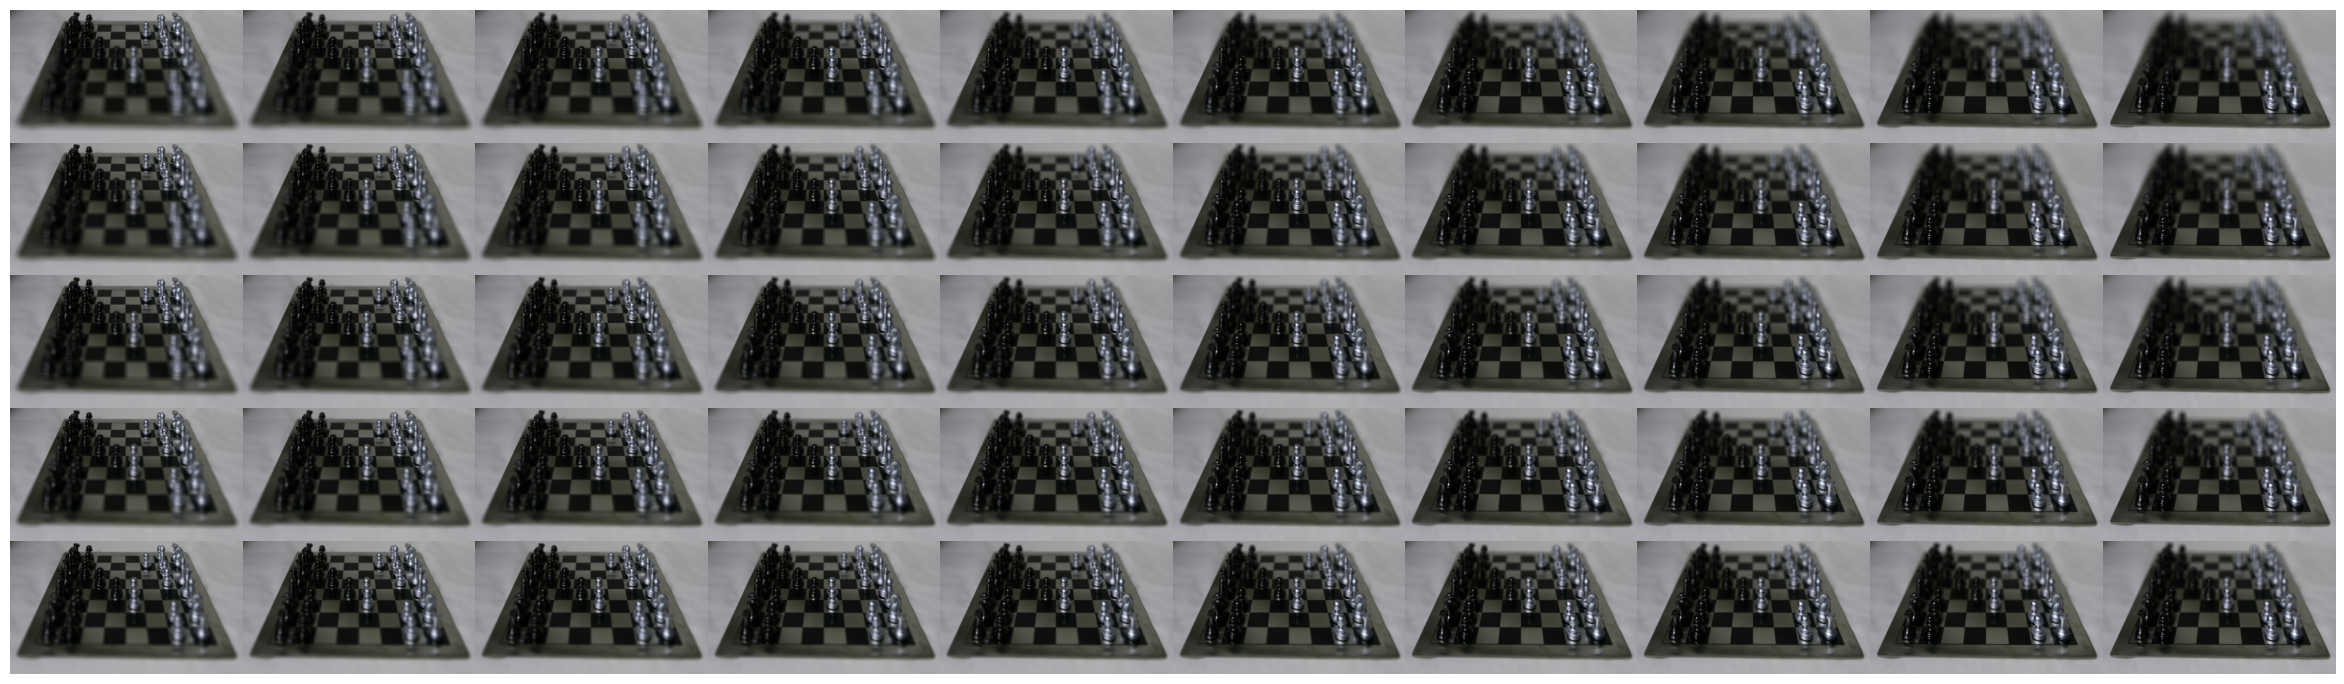

In [348]:
fig = plt.figure(figsize=(30., 30.))
grid = ImageGrid(fig,111,
                nrows_ncols=(5, 10),  # creates 2x2 grid of axes
                axes_pad=0,  # pad between axes in inch.
                )

for ax, im in zip(grid, af.reshape(5*10, 400, 700, 3)):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.astype(np.uint8))
    ax.axis('off')
plt.axis('off')
plt.show()

In [234]:
from moviepy.editor import *

In [375]:
clip = VideoFileClip("DSC_0055.MOV").subclip(0, 6).resize(0.5)
frames = clip.iter_frames(fps = 30)
frames = np.array(list(frames))
print(frames.shape)

(180, 360, 640, 3)


In [358]:
mid_frame = len(frames)//2

(-0.5, 49.5, 49.5, -0.5)

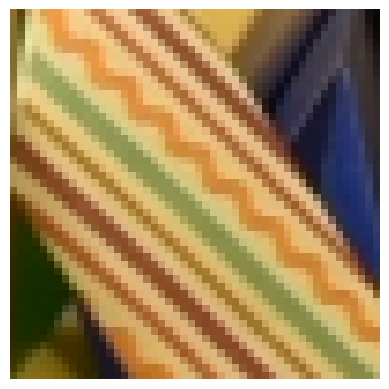

In [426]:
template = frames[mid_frame, 300:350, 400:450,:]
plt.imshow(template)
plt.axis('off')

In [424]:
template = frames[mid_frame, 100:150, 250:300,:]
search_window = np.array([75, 250, 250, 300], dtype=np.int32)

In [415]:
from scipy.interpolate import RectBivariateSpline

def template_matching(I_t, g, search_window):

    i_l, i_h, j_l, j_h = searchWindow
    h, w = g.shape
    box_filter = 1/(h*w) * np.ones_like(g)
    It_bar = correlate2d(It, box_filter, mode='same')
    
    final_t = np.zeros((i_h-i_l+1, j_h-j_l+1))
    for i in range(i_l, i_h):
        for j in range(j_l, j_h):
            # for pixel (i, j)
            final_t[i-i_l, j-j_l] = calculate_norm_cross_correlation(It[i:i+h, j:j+w], It_bar[i:i+h, j:j+w], g)
            
    sx, sy = np.unravel_index(np.argmax(h_t, axis=None), h_t.shape)
    return sx, sy

def calculate_norm_cross_correlation(It, It_bar, g, eps=1e-8):
    
    g_mean = np.mean(g)
    g = g - g_mean + 1e-8
    
    I_t -= It_bar
    
    num = np.sum(np.multiply(g, I_t))
    left_d = np.sum(g**2)
    right_d = np.sum(I_t**2)
    denom = np.sqrt(left_d * right_d + eps)
    
    return num/denom

def unstructured_refocusing(frames, template, search_window):
    
    final_frames = np.zeros(frames.shape[1:])
    template = lRGB2XYZ(template)[:, :, 1]
    
    for fk, frame in enumerate(video_frames):
        
        frame_L = lRGB2XYZ(frame)[:, :, 1]
        sx, sy = template_matching(frame_L, template, search_window)
        
        uu = np.arange(frame.shape[0])
        vv = np.arange(frame.shape[1])
        ss = uu + sx
        tt = vv + sy
        ssl, ttl = np.meshgrid(ss, tt)
        shifted_frame = np.zeros(frame.shape)  
        
        for c in range(frame.shape[2]):
            finterp = RectBivariateSpline(uu, vv, frame[:, :, c])
            shifted_frame[:, :, c] = finterp(ssl, ttl, grid=False).T
        final_frames += shifted_frame
        
    return sum_frames/len(video_frames)

In [425]:
final_refocused_result = unstructured_refocusing(frames, template, search_window)

(360, 640, 3)
processing frame 0
25 37
applying interpolation..
255.0000000000001 -1.0360901343844016e-14
processing frame 1
25 37
applying interpolation..
255.0000000000001 -1.0362027799656824e-14
processing frame 2
25 37
applying interpolation..
255.00000000000014 -1.0363508223935063e-14
processing frame 3
24 37
applying interpolation..
255.0000000000001 -1.1836907057718458e-14
processing frame 4
24 37
applying interpolation..
255.0000000000001 -1.1338189338640949e-14
processing frame 5
24 37
applying interpolation..
255.00000000000014 -1.1582970858377376e-14
processing frame 6
24 37
applying interpolation..
255.0000000000001 -1.644317161845375e-14
processing frame 7
24 37
applying interpolation..
255.00000000000014 -1.2757734367100218e-14
processing frame 8
24 37
applying interpolation..
255.0000000000001 -1.3463020536034261e-14
processing frame 9
24 37
applying interpolation..
255.0000000000001 -1.8414677095649503e-14
processing frame 10
24 37
applying interpolation..
255.000000000

(-0.5, 639.5, 359.5, -0.5)

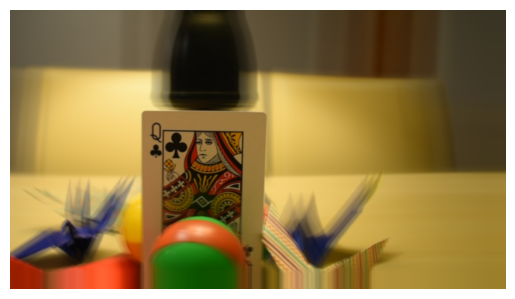

In [391]:
plt.axis('off')
plt.imshow(final_refocused_result.astype(np.uint8))
plt.axis('off')